# We are classifying images in the cifar dataset

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
batch_size = 4

## what the heck this do
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)
torchvision.get_image_backend()
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

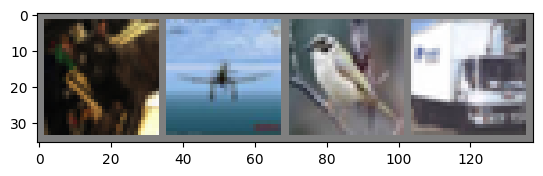

cat   plane bird  truck


In [3]:
import matplotlib.pyplot as plt
import numpy as np
# Show an image
def imshow(img):
    img = img/2 + .5 # unnormalize, 
    #from -1, 1; to -.5 to .5; to 0 to 1
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1,2,0))
    plt.imshow(npimg)
    plt.show()
    
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

# labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [4]:
# Define the CNN
# Takes in a 3 channel 
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(12, 32, 5)
        self.fc1 = nn.Linear(32 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.fc4 = nn.Linear(32 * 5 * 5, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # dont flatten batch, a1
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = self.fc3(x)
        x = self.fc4(x)
        return x

net = Net()
        

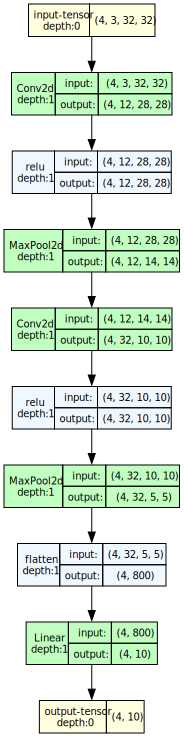

In [5]:
import torchvision
from torchview import draw_graph

# get on batch to see size

model_graph = draw_graph(net, input_size=images.shape, expand_nested=True)
model_graph.visual_graph

In [ ]:
# loss and optimizer

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=.9)

In [ ]:
for epoch in range(2): # 2 passes
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        
        inputs, labels = data
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # logger
        running_loss += loss.item()
        if i%2000 == 1999:
            print(f'[{epoch+1}, {i + 1:5d}] loss: {running_loss/2000:.3f}')
            running_loss = 0.0
            
print('Finished')

[1,  2000] loss: 1.887
[1,  4000] loss: 1.592
[1,  6000] loss: 1.464
[1,  8000] loss: 1.392
[1, 10000] loss: 1.331
[1, 12000] loss: 1.286
[2,  2000] loss: 1.226
[2,  4000] loss: 1.196


KeyboardInterrupt: 

In [ ]:
torch.save(net.state_dict(), './cifar_net.pth')

In [ ]:
# See how the testing did
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        
        outputs = net(images)
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on 10k test images is {100 * correct//total}%')

## With lower conv2d (6, 16) acc is 55
## Upping it to 12, 32 makes it 60
## Making the linear end layers larger nums at first makes it 57
## undid that. Removing momentum from optimizer, accuracy is 39! thats horrible
## undid that. Now increased epochs to 6, increased to 66%. 
## undid that as took a long time. Changed LR to .005, went down to 46%. bad. Undid it.
## changed to only one linear FC layer, acc is 60%. So its the same...

Accuracy on 10k test images is 60%


In [ ]:
## Switching to a configurable NN trainer. This can be resused.
def train(model, data, batch_size=64, weight_decay=0.0,
          optimizer="sgd", learning_rate=0.1, momentum=0.9,
          data_shuffle=True, num_epochs=4):
    train_loader = torch.utils.data.DataLoader(data, 
                                               batch_size=batch_size,
                                               shuffle=data_shuffle
                                               )
    # loss func
    criterion = nn.CrossEntropyLoss()
    # optimizer
    assert optimizer in ("sgd", "adam") # has to be one of deez
    if optimizer == "sgd":
        optimizer = optim.SGD(model.parameters(),
                              lr=learning_rate,
                              momentum=momentum,
                              weight_decay=weight_decay)
    else:
        optimmizer = optim.Adam(model.parameters(),
                                lr=learning_rate,
                                weight_decay=weight_decay)
    
    # track learning curve
    iters, losses, train_acc, val_acc = [], [], [], []
    
    # training
    n = 0
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            if imgs.size()[0] < batch_size: # do we need this? what it do
                continue
            
            model.train()
            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            # save the info
            iters.append(n)
            losses.append(loss.item()) # average loss per img
            train_acc.append(get_accuracy(model, train=True)) # train acc
            val_acc.append(get_accuracy(model, train=False))
            n+=1
    # plottin
    plt.title("Learning Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()
    
    plt.title("Learning Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc="best")
    plt.show()
    
    print(f"Final Training Accuracy: {train_acc[-1]}")
    print(f"Final Validation Accuracy: {val_acc[-1]}")

def get_accuracy(model, train=False):
    if train:
        data = torch.utils.data.DataLoader(trainset, batch_size=4096)
    else:
        data = torch.utils.data.DataLoader(testset, batch_size=1024)
    model.eval() # Annotate model for evaluation
    correct = 0
    total = 0
    for imgs, labels in data:
        output = model(imgs)
        pred = output.max(1, keepdim=True)[1] # get index of the max log-probability?
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct/total


In [ ]:
model = Net()
train(model, trainset, learning_rate=0.1)

KeyboardInterrupt: 